# Introduction
Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). But, it’s not always clear whether a person’s words are actually announcing a disaster. 

In this competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. I have access to a dataset of 10,000 tweets that were hand classified.

This is a competition on Kaggle at the following link https://www.kaggle.com/competitions/nlp-getting-started/overview. The submissions are evaluated using F1 between the predicted and expected answers.

## Description of dataset
There are 3 files in the data folder: train.csv, test.csv and sample_submission.csv. Each sample in the train and test set has the following information: the text of a tweet, a keyword from that tweet (although this may be blank!), the location the tweet was sent from (may also be blank). Columns contain: id - a unique identifier for each tweet, text - the text of the tweet, location - the location the tweet was sent from (may be blank), keyword - a particular keyword from the tweet (may be blank), target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0).

You can download the dataset from Kaggle at following link https://www.kaggle.com/competitions/nlp-getting-started/data.

## Libraries Import

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import glob
import nltk
import warnings
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Activation, Embedding 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict, Counter
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data Analysis and Data Cleaning (EDA)

In [2]:
df_train = pd.read_csv('data/DisasterTweets/train.csv', encoding ='utf-8')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
df_train.shape

(7613, 5)

There are about 7613 entries with 5 columns. However, some columns contain less than 7613 entries (blank entries).

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The 'keyword' and 'location' columns contain some NaN values. The target column contains the label for the text as either positive 1 (disaster) or negative 0(no disaster).

<Axes: xlabel='target', ylabel='count'>

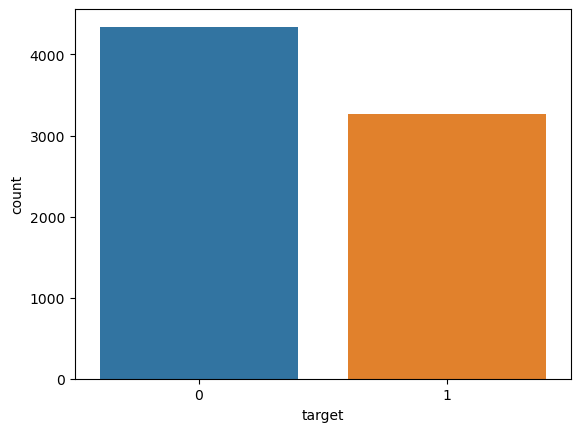

In [5]:
sns.countplot(x = 'target', data= df_train)

In [6]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

There are about 4342 negative labels and 3271 positive labels. The negative label is rougly 57% while the positive label is rougly 43% of the whole train dataset. 

In [7]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
df_train.duplicated().sum()

0

The keyword and location columns contain NA values. However since our task is to use to classify the text based on NLP, we do not need keyword and location columns values in our training model so there is no need to remove them or replace those NA values. Furthermore, we do not have any duplicated in our train set.

In [9]:
df_train['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [10]:
df_test = pd.read_csv('data/DisasterTweets/test.csv', encoding ='utf-8')

In [11]:
df_test.shape

(3263, 4)

In [12]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


The test dataset is similar to the train dataset except that it does not have a target column. There are about 3263 entries to be classified in the test set. 

In [13]:
for i in range(10):
    print(df_train.loc[i,'text'])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...


Looking at some samples of the tweets from the train dataset, I can see the texts contain puncuation, HTML markups. So I would have to remove them. I developed a function that uses regular expression to remove those non-letters characters from the text columns.

In [14]:
def preprocessor(text):
    text.strip()
    text = re.sub(r'\b\w{1,2}\b', ' ', text.lower())
    text = re.sub('[\W\d]+', ' ', text)
    return text.strip()

In [15]:
for i in range(10):
    print(preprocessor(df_train.loc[i,'text']))

our deeds are the reason this earthquake may allah forgive all
forest fire near ronge sask canada
all residents asked shelter place are being notified officers other evacuation shelter place orders are expected
people receive wildfires evacuation orders california
just got sent this photo from ruby alaska smoke from wildfires pours into school
rockyfire update california hwy closed both directions due lake county fire cafire wildfires
flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
top the hill and can see fire the woods
there emergency evacuation happening now the building across the street
afraid that the tornado coming our area


The function seems to work well on some example provided above. Let's apply it to the whole text column of the train dataset.

In [16]:
df_train['text'] = df_train['text'].apply(preprocessor)
df_train['text']

0       our deeds are the reason this earthquake may a...
1                      forest fire near ronge sask canada
2       all residents asked shelter place are being no...
3       people receive wildfires evacuation orders cal...
4       just got sent this photo from ruby alaska smok...
                              ...                        
7608    two giant cranes holding bridge collapse into ...
7609    aria_ahrary thetawniest the out control wild f...
7610                utc km volcano hawaii http zdtoyd ebj
7611    police investigating after bike collided with ...
7612    the latest more homes razed northern californi...
Name: text, Length: 7613, dtype: object

Stop-word removal: Stop-words are simply the words that are very common in all sort of texts and probably contain no useful information that can be used. Examples of stop-words are *is, are, and, have, has, like, etc.*
We can use the 'stopwords' libary from NLTK library.

In [17]:
def stop_words(text):
    stop = stopwords.words('english')
    return ' '.join([w for w in text.split() if w not in stop])

In [18]:
df_train['text'] = df_train['text'].apply(stop_words)
df_train['text']

0               deeds reason earthquake may allah forgive
1                      forest fire near ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    aria_ahrary thetawniest control wild fires cal...
7610                utc km volcano hawaii http zdtoyd ebj
7611    police investigating bike collided car little ...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

After successfully remove all stop words, the text now probably contains the useful English words for the model to learn and train. Let's find the most frequent words in the train dataset.

In [19]:
def vocab_count(docs):
    vocab = defaultdict(int)
    for doc in docs:
        for token in doc.split():            
            if token not in vocab:
                    vocab[token] = 1 
            else:
                    vocab[token] += 1
    return vocab

http : 4309

https : 411

like : 348

amp : 344

fire : 254

get : 229

new : 226

via : 220

news : 210

people : 200



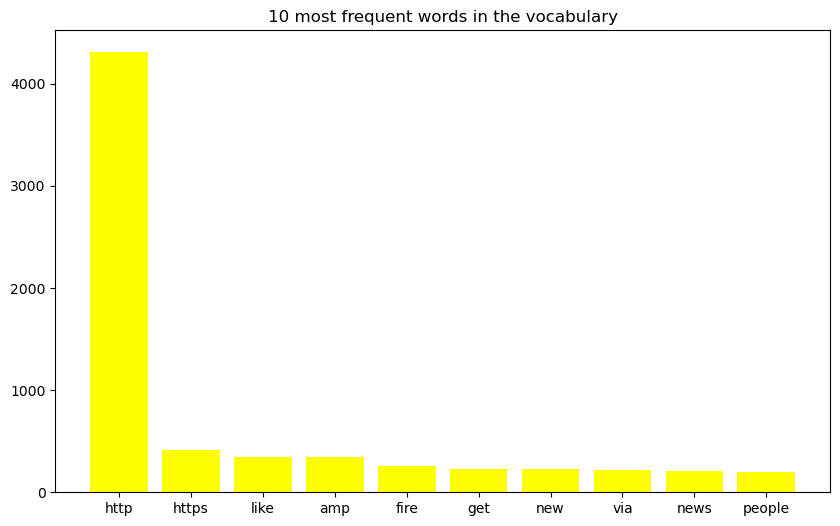

In [55]:
bag_of_words = vocab_count(df_train['text'])

bag_of_words = {word:count for word,count in sorted(bag_of_words.items(), reverse = True, key = lambda item:item[1])}
words = list(bag_of_words.keys())
counts = list(bag_of_words.values())

for i in range(0,10):
    print(words[i] +' : '+ str(counts[i]) + '\n')

plt.figure(figsize=(10,6))
plt.title('10 most frequent words in the vocabulary')
plt.bar(words[0:10],counts[0:10], color ='yellow')
plt.savefig('10_most_frequent_word.png')
plt.show()

The most common word is 'http'. This is definitely not an English word but it might contain useful information such as links to some disaster news for example, and people like to tweet or retweet from other links. Other useful words are fire, news, people. 

In [21]:
df_test['text'] = df_test['text'].apply(preprocessor)
df_test['text']

0                        just happened terrible car crash
1       heard about earthquake different cities stay s...
2       there forest fire spot pond geese are fleeing ...
3                   apocalypse lighting spokane wildfires
4                 typhoon soudelor kills china and taiwan
                              ...                        
3258    earthquake safety los angeles safety fasteners...
3259    storm worse than last hurricane city amp other...
3260        green line derailment chicago http utbxlcbiuy
3261    meg issues hazardous weather outlook hwo http ...
3262    cityofcalgary has activated its municipal emer...
Name: text, Length: 3263, dtype: object

In [22]:
df_test['text'] = df_test['text'].apply(stop_words)
df_test['text']

0                             happened terrible car crash
1       heard earthquake different cities stay safe ev...
2       forest fire spot pond geese fleeing across str...
3                   apocalypse lighting spokane wildfires
4                     typhoon soudelor kills china taiwan
                              ...                        
3258    earthquake safety los angeles safety fasteners...
3259    storm worse last hurricane city amp others har...
3260        green line derailment chicago http utbxlcbiuy
3261    meg issues hazardous weather outlook hwo http ...
3262    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object

I also need to clean the text in the test dataset so that later I will have to create a test data from the test dataset for model prediction.

## Data Preparation
To prepare data for input to a Neural Network, I need to encode the text into numeric values. To do this, I will first find the unique words (tokens) in the train dataset. Keras provides a text Tokenizer that can tokenize the text and build a vocabulary. Next, I'm going to map each unique word to a unique integer. Tokernizer class has a function called texts_to_sequence that can convert a text to a sequence of integer based on the internal vocabulary. 

In [23]:
# Convert text to a list of strings
text_list = df_train['text'].tolist()

# Tokenize the text and build the vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_list)

# Encode text and labels and pad the sequences
max_sequence_length = 32  # Set the maximum sequence length
ds_train = df_train['text'].apply(lambda x: tokenizer.texts_to_sequences([x])[0])
ds_train = pad_sequences(ds_train, maxlen=max_sequence_length)

labels = df_train['target'].values

In [24]:
# Create a tf.data.Dataset from train_data and labels
train_dataset = tf.data.Dataset.from_tensor_slices((ds_train, labels))

In [25]:
# Shuffle and batch the dataset
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset), seed=42, reshuffle_each_iteration = False)
train_data = train_dataset.take(6000)
valid_data = train_dataset.skip(6000)

In [26]:
batch_size = 32
train_data = train_data.batch(batch_size)
valid_data = valid_data.batch(batch_size)

In the above code, I have created a tensor train_dataset that contains the train senquences of texts, and the train labels. Also I shuffled the tensor dataset and took the first 6000 entries for training data, and the rest (1613) for validation data. It's time to build the model.

# Models Training

## Bidirectional Long Short Term Memory (Bi LSTM) Model

During the data preparation in the previous step, I generated sequences of the same length. The elements of these sequences were integer numbers that corresponded to the indices of unique words. These word indices can be converted into input features in several different ways. One approach is to map each word to a vector of a fixed size with real valued elements. We can use finite-sized vectors to represent an infinite number of real numbers. This is the idea behind embedding. Given the number of unique words, we can select the size of the embedding vectors to be much smaller than the number of unique words to represent the entire vocabulary as input features. You can think of it as a reduction in dimensionality of the feature space to decrease the effect of the curse of dimensionality. Given a set of tokens of size n+2 (n is the size of the token set, plus index 0 is reserved for the padding holder, and n+1 is for the words not present in the token set), an embedding matrix of size (n+2)x embedding_dim will be created where each row of this matrix represents numerical feratures associated with a token. In practice, creating an embedding layer can simply be done using keras.layers.Embedding.

In [27]:
vocab_size = len(bag_of_words) + 2
embedding_dim = 100
bi_lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim = embedding_dim, name = 'embed-layer'),
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, name='lstm-layer'),name='bidir-lstm'),
    Dropout(0.5),
    Dense(256,activation = 'relu'),
    Dropout(0.5),
    Dense(1,activation = 'sigmoid')
])

Since we might have long sequences, I used an LSTM layer to account for long-term effects. In addition, I put the LSTM layer inside a Bidirectional wrapper, which will make the recurrent layers pass through the input sequences from both directions, start to end, as well as the reverse direction. I also used Adam optimizer and binary_crossentropy as the loss function. The summary of Bi LSTM model is below. 

In [28]:
bi_lstm_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics =['accuracy'])
bi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed-layer (Embedding)     (None, None, 100)         2208300   
                                                                 
 bidir-lstm (Bidirectional)  (None, 256)               234496    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2508845 (9.57 MB)
Trainable params: 250884

In [29]:
# Define the EarlyStopping callback to stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [30]:
# Create a ModelCheckpoint callback to save the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_disaster_model.h5',
    monitor='val_loss',  
    mode='min',              
    save_best_only=True,     
    save_weights_only=False, 
    verbose=1
)

I created an early stopping callback to stop training in order to avoid overfitting. I also created a checkpoint callback where I saved the best model so I could load from it later. It's time to train the model. Let's set the number of epochs = 10.

In [31]:
# Fit the model to the data using the generators and the EarlyStopping and ModelCheckpoint callbacks
epochs = 10  
history = bi_lstm_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint_callback] 
)

Epoch 1/10
187/188 [============================>.] - ETA: 0s - loss: 0.5505 - accuracy: 0.7114
Epoch 1: val_loss improved from inf to 0.45498, saving model to best_disaster_model.h5
188/188 [==============================] - 11s 44ms/step - loss: 0.5500 - accuracy: 0.7118 - val_loss: 0.4550 - val_accuracy: 0.7911
Epoch 2/10
  3/188 [..............................] - ETA: 7s - loss: 0.4831 - accuracy: 0.7604

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/188 [============================>.] - ETA: 0s - loss: 0.2577 - accuracy: 0.8989
Epoch 2: val_loss did not improve from 0.45498
188/188 [==============================] - 8s 42ms/step - loss: 0.2574 - accuracy: 0.8990 - val_loss: 0.5552 - val_accuracy: 0.7874
Epoch 3/10
187/188 [============================>.] - ETA: 0s - loss: 0.1163 - accuracy: 0.9621
Epoch 3: val_loss did not improve from 0.45498
188/188 [==============================] - 8s 42ms/step - loss: 0.1162 - accuracy: 0.9620 - val_loss: 0.6648 - val_accuracy: 0.7644
Epoch 4/10
187/188 [============================>.] - ETA: 0s - loss: 0.0565 - accuracy: 0.9841
Epoch 4: val_loss did not improve from 0.45498
188/188 [==============================] - 8s 42ms/step - loss: 0.0564 - accuracy: 0.9842 - val_loss: 0.7849 - val_accuracy: 0.7514
Epoch 5/10
188/188 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9910
Epoch 5: val_loss did not improve from 0.45498
188/188 [==============================] - 

Training is completed after 6 epochs. Let's draw the plots for loss and accuracy.

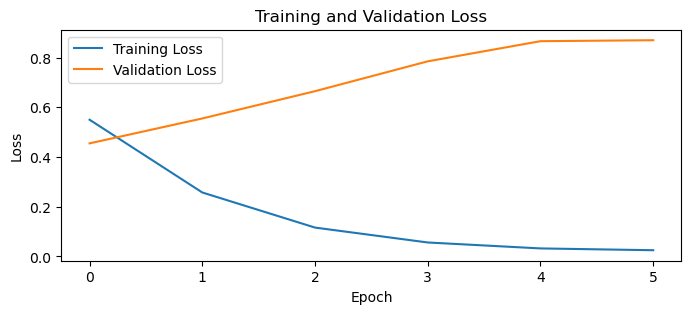

In [32]:
# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the plot
plt.figure(figsize=(8,3))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.show()

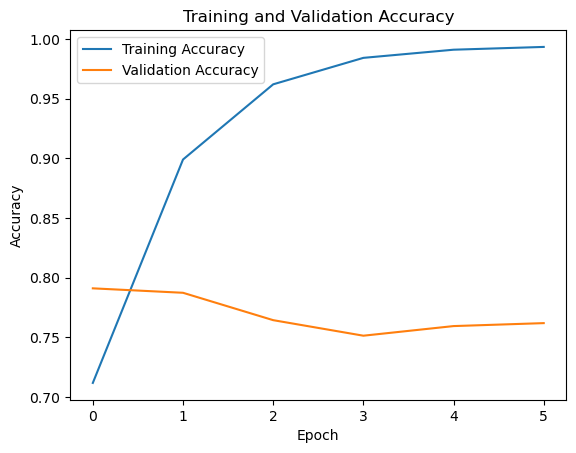

In [33]:
# Extract the training and validation loss from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create the plot
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.show()


In [34]:
best_bi_lstm_model = tf.keras.models.load_model('best_disaster_model.h5')

valid_loss, valid_accuracy = best_bi_lstm_model.evaluate(valid_data)
print("Validation Loss For Best LSTM Model:", valid_loss)
print("Valid Accuracy For Best LSTM Model:", valid_accuracy)

51/51 [==============================] - 1s 7ms/step - loss: 0.4550 - accuracy: 0.7911
Validation Loss For Best LSTMM Model: 0.45498111844062805
Valid Accuracy For Best LSTM Model: 0.7910725474357605


I got the best model at the first epoch = 1. I could see the validation loss increased and validation accuracy decreased after the first epoch. Validation accuracy for Bi LSTModel is 0.791 and the validaion loss is about 0.455. Let's do some tuning for the model.

### Hyperparameters Tuning
I will unfreeze some layers for fine tuning, and I also adjusted the learning rate from 0.001 to 0.0001. Then I will fit another 5 epochs from the best model for fine tuning.

In [35]:
# Unfreeze some layers for fine-tuning
for layer in best_bi_lstm_model.layers:
    layer.trainable = True

# Compile the best model again with a lower learning rate for fine-tuning
best_bi_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit the best model to the data again for fine-tuning
fine_tune_epochs = 5  
history_fine_tune = best_bi_lstm_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=fine_tune_epochs,
    callbacks=[checkpoint_callback]
)

Epoch 1/5
187/188 [============================>.] - ETA: 0s - loss: 0.2475 - accuracy: 0.9049
Epoch 1: val_loss did not improve from 0.45498
188/188 [==============================] - 11s 44ms/step - loss: 0.2479 - accuracy: 0.9047 - val_loss: 0.4965 - val_accuracy: 0.7954
Epoch 2/5
187/188 [============================>.] - ETA: 0s - loss: 0.2221 - accuracy: 0.9144
Epoch 2: val_loss did not improve from 0.45498
188/188 [==============================] - 8s 42ms/step - loss: 0.2226 - accuracy: 0.9143 - val_loss: 0.5184 - val_accuracy: 0.7954
Epoch 3/5
188/188 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9238
Epoch 3: val_loss did not improve from 0.45498
188/188 [==============================] - 8s 41ms/step - loss: 0.1985 - accuracy: 0.9238 - val_loss: 0.5382 - val_accuracy: 0.7985
Epoch 4/5
187/188 [============================>.] - ETA: 0s - loss: 0.1776 - accuracy: 0.9347
Epoch 4: val_loss did not improve from 0.45498
188/188 [==========================

In [36]:
best_bi_lstm_model = tf.keras.models.load_model('best_disaster_model.h5')

valid_loss_list = []
valid_accuracy_list = []
valid_loss, valid_accuracy = best_bi_lstm_model.evaluate(valid_data)
valid_loss_list.append(valid_loss)
valid_accuracy_list.append(valid_accuracy)

print("Validation Loss For Best LSTM Model After Tuning:", valid_loss)
print("Validation Accuracy For Best LSTM Model After Tuning:", valid_accuracy)

51/51 [==============================] - 1s 8ms/step - loss: 0.4550 - accuracy: 0.7911
Validation Loss For Best LSTM Model After Tuning: 0.45498111844062805
Validation Accuracy For Best LSTM Model After Tuning: 0.7910725474357605


After tuning completed, the validation loss and accuracy did not change because it seems like I got the best model alreay and tuning did not really make the validation loss smaller.

### Test Set Evaluation
In order to test our model on the test set, I needed to create a test dataset as same as I did for the train dataset. Using texts_to_sequences function from Keras, I was able to have the test set ready for evaluation.

In [37]:
# Convert text to a list of strings
text_list_test = df_test['text'].tolist()

# Encode text for test data using the same tokenizer as used for training data
test_data = df_test['text'].apply(lambda x: tokenizer.texts_to_sequences([x])[0])
test_data = pad_sequences(test_data, maxlen=max_sequence_length)

# Convert the padded sequences to a TensorFlow Dataset
test_data = tf.data.Dataset.from_tensor_slices(test_data)

# Batch the test data
batch_size = 1
test_data = test_data.batch(batch_size)

In [38]:
# Make predictions on the test data
test_predictions = best_bi_lstm_model.predict(test_data, verbose =1)

3263/3263 [==============================] - 12s 4ms/step


In [39]:
print(test_predictions)

[[0.57789534]
 [0.5168517 ]
 [0.96613103]
 ...
 [0.7189995 ]
 [0.76343167]
 [0.58129025]]


Because the predictions are the probabilities, so I need to covert it to binary labels by using the threshold p =0.5 

In [40]:
# Convert predictions to binary labels (0 or 1)
binary_predictions = [1 if pred >= 0.5 else 0 for pred in test_predictions]

In [41]:
def test_submit(y_pred, filename):
    try:
        submit_df = df_test
        submit_df['target'] = y_pred
        submit_df = submit_df.drop(['keyword','location','text'], axis =1)
        submit_df.to_csv(filename, index=False)
        print('File saved to ',filename)
    except:
        print('Error trying to create ', filename)

In [59]:
test_submit(binary_predictions,'disaster_tweets_submission.csv')
print('F1 Score for Bi LSTM Model: 0.79528')

File saved to  disaster_tweets_submission.csv
F1 Score for Bi LSTM Model: 0.79528


**After submitting the file on Kagge for evaluation, Kaggle reported the F1 score is 79.53% for the first model.** 

## Simple RNN Model
Instead of using the LSTM layer, I decided to use two SimpleRNN layers with increasing sizes after the Embedding layer. I also added Dropout layer in between each SimpleRNN layer and before the output layer to decrease the effect of unbalaced data.

In [43]:
simple_rnn_model = Sequential()
simple_rnn_model.add(Embedding(input_dim=vocab_size, output_dim = embedding_dim, name = 'embed-layer'))
simple_rnn_model.add(SimpleRNN(64, return_sequences = True))
simple_rnn_model.add(Dropout(0.3))
simple_rnn_model.add(SimpleRNN(128))
simple_rnn_model.add(Dropout(0.3))
simple_rnn_model.add(Dense(256, activation = 'relu'))
simple_rnn_model.add(Dropout(0.5))
simple_rnn_model.add(Dense(1, activation ='sigmoid'))

In [44]:
simple_rnn_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics =['accuracy'])
simple_rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed-layer (Embedding)     (None, None, 100)         2208300   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          10560     
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               24704     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_4 (Dropout)         (None, 256)              

In [45]:
# Create a ModelCheckpoint callback to save the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_rnn_model.h5',
    monitor='val_loss',  
    mode='min',              
    save_best_only=True,     
    save_weights_only=False, 
    verbose=1
)

The summary of my Simple RNN model is above. I also need another checkpoint callback to save my best model for training. Let's do some training for the second model.

In [46]:
# Fit the model to the data using the generators and the EarlyStopping and ModelCheckpoint callbacks
epochs = 10  
history = simple_rnn_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint_callback] 
)

Epoch 1/10
187/188 [============================>.] - ETA: 0s - loss: 0.6154 - accuracy: 0.6536
Epoch 1: val_loss improved from inf to 0.50521, saving model to best_rnn_model.h5
188/188 [==============================] - 5s 21ms/step - loss: 0.6148 - accuracy: 0.6538 - val_loss: 0.5052 - val_accuracy: 0.7737
Epoch 2/10
  7/188 [>.............................] - ETA: 3s - loss: 0.4984 - accuracy: 0.7634

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


186/188 [============================>.] - ETA: 0s - loss: 0.2781 - accuracy: 0.8863
Epoch 2: val_loss did not improve from 0.50521
188/188 [==============================] - 4s 20ms/step - loss: 0.2768 - accuracy: 0.8868 - val_loss: 0.6058 - val_accuracy: 0.7793
Epoch 3/10
187/188 [============================>.] - ETA: 0s - loss: 0.0887 - accuracy: 0.9703
Epoch 3: val_loss did not improve from 0.50521
188/188 [==============================] - 4s 20ms/step - loss: 0.0885 - accuracy: 0.9703 - val_loss: 0.7726 - val_accuracy: 0.7409
Epoch 4/10
187/188 [============================>.] - ETA: 0s - loss: 0.0472 - accuracy: 0.9866
Epoch 4: val_loss did not improve from 0.50521
188/188 [==============================] - 4s 19ms/step - loss: 0.0472 - accuracy: 0.9867 - val_loss: 1.0796 - val_accuracy: 0.6900
Epoch 5/10
187/188 [============================>.] - ETA: 0s - loss: 0.0294 - accuracy: 0.9910
Epoch 5: val_loss did not improve from 0.50521
188/188 [==============================] - 

Training is completed after 6 epochs. Let's take a look at the plots for loss and accuracy.

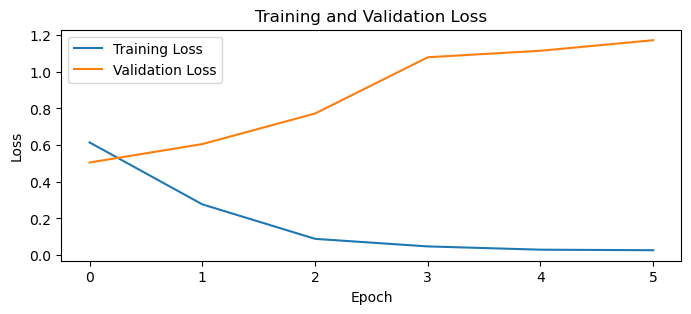

In [56]:
# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the plot
plt.figure(figsize=(8,3))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.show()

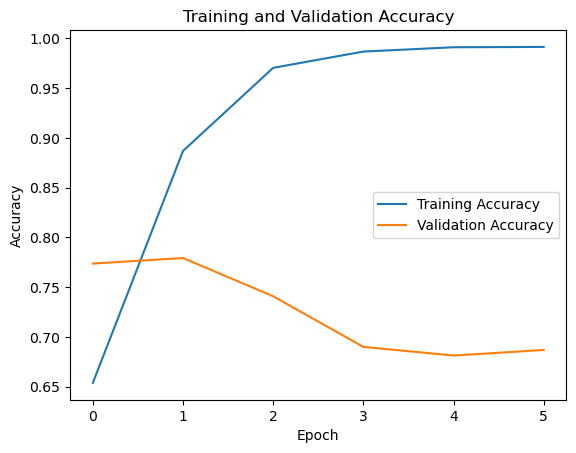

In [57]:
# Extract the training and validation loss from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create the plot
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.show()

In [47]:
best_rnn_model = tf.keras.models.load_model('best_rnn_model.h5')

valid_loss, valid_accuracy = best_rnn_model.evaluate(valid_data)
print("Validation Loss For Best Simple RNN Model:", valid_loss)
print("Validation Accuracy For Best Simple RNN Model:", valid_accuracy)

51/51 [==============================] - 0s 3ms/step - loss: 0.5052 - accuracy: 0.7737
Validation Loss For Best Simple RNN Model: 0.5052093863487244
Validation Accuracy For Best Simple RNN Model: 0.7737135887145996


I got the best model at the first epoch = 1. I could see the validation loss increased and validation accuracy decreased after the first epoch. Validation accuracy for Simple RNN Model is 0.774 and the validaion loss is about 0.505. Let's do some tuning for the model.

### Hyperparameters Tuning
I will unfreeze some layers for fine tuning, and I also adjusted the learning rate from 0.001 to 0.0001. Then I will fit another 5 epochs from the best model for fine tuning.

In [48]:
# Unfreeze some layers for fine-tuning
for layer in best_rnn_model.layers:
    layer.trainable = True

# Compile the best model again with a lower learning rate for fine-tuning
best_rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit the best model to the data again for fine-tuning
fine_tune_epochs = 5  
history_fine_tune = best_rnn_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=fine_tune_epochs,
    callbacks=[checkpoint_callback]
)

Epoch 1/5
187/188 [============================>.] - ETA: 0s - loss: 0.2794 - accuracy: 0.8929
Epoch 1: val_loss did not improve from 0.50521
188/188 [==============================] - 5s 20ms/step - loss: 0.2792 - accuracy: 0.8930 - val_loss: 0.5449 - val_accuracy: 0.7762
Epoch 2/5
187/188 [============================>.] - ETA: 0s - loss: 0.2242 - accuracy: 0.9144
Epoch 2: val_loss did not improve from 0.50521
188/188 [==============================] - 4s 19ms/step - loss: 0.2239 - accuracy: 0.9147 - val_loss: 0.5906 - val_accuracy: 0.7644
Epoch 3/5
187/188 [============================>.] - ETA: 0s - loss: 0.1590 - accuracy: 0.9410
Epoch 3: val_loss did not improve from 0.50521
188/188 [==============================] - 4s 19ms/step - loss: 0.1588 - accuracy: 0.9412 - val_loss: 0.6601 - val_accuracy: 0.7508
Epoch 4/5
188/188 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9620
Epoch 4: val_loss did not improve from 0.50521
188/188 [===========================

In [49]:
best_rnn_model = tf.keras.models.load_model('best_rnn_model.h5')

valid_loss, valid_accuracy = best_rnn_model.evaluate(valid_data)
valid_loss_list.append(valid_loss)
valid_accuracy_list.append(valid_accuracy)

print("Validation Loss For Best Simple Model After Tuning:", valid_loss)
print("Validation Accuracy For Best Simple Model After Tuning:", valid_accuracy)

51/51 [==============================] - 0s 2ms/step - loss: 0.5052 - accuracy: 0.7737
Validation Loss For Best Simple Model After Tuning: 0.5052093863487244
Validation Accuracy For Best Simple Model After Tuning: 0.7737135887145996


After tuning completed, the validation loss and accuracy did not change because it seems like I got the best second model alreay, and tuning did not really make the validation loss smaller. It's time to make some predictions.

### Test Set Evaluation

In [50]:
# Make predictions on the test data
test_predictions = best_rnn_model.predict(test_data, verbose =1)

# Print the predicted binary labels
print(test_predictions)

3263/3263 [==============================] - 5s 1ms/step
[[0.25781274]
 [0.487879  ]
 [0.9903128 ]
 ...
 [0.38670793]
 [0.9724892 ]
 [0.48764813]]


Because the predictions are the probabilities, so I need to covert it to binary labels by using the threshold p =0.5 

In [51]:
# Convert predictions to binary labels (0 or 1)
binary_predictions = [1 if pred >= 0.5 else 0 for pred in test_predictions]

In [58]:
test_submit(binary_predictions,'disaster_tweets_submission.csv')
print('F1 Score for Simple RNN Model: 0.77842')

File saved to  disaster_tweets_submission.csv
F1 Score for Simple RNN Model: 0.77842


**After submitting the file on Kagge for evaluation, Kaggle reported the test accuracy is 77.84% for the second model.** 

# Result, Analysis and Discussion 

In [60]:
f1_score_list = [0.79528,0.77842]
data = {'Validation Accuracy': valid_accuracy_list, 'Validation Loss': valid_loss_list, 'F1 Score':test_accuracy_list}
result_df = pd.DataFrame(data)
result_df.index = ['Bi LSTM', 'Simple RNN']
print('Model Results Comparision Table')
result_df

Model Results Comparision Table


,Validation Accuracy,Validation Loss,F1 Score
Bi LSTM,0.791073,0.454981,0.79528
Simple RNN,0.773714,0.505209,0.77842


***The table shows that a  neural network such as a Simple RNN model has an F1 score of 77.84% on the test set. Meanwhile, a more complexed model like Bi LSTM has an F1 score 79.53% on the test set. This shows a simple RNN model underperforms compared to Bi LSTM model. In overall, our F1 scores are acceptable but not high, or considered as very good. But in order to achieve an almost perfect score on F1 (like 0.98 to 1), maybe we might need a lot more training data. This is probably a setback compared to other supervised learning methods. However, considered that our neural nework works just learnt to classify based on the sequences of integer numbers that represent words in such a small dataset, the result is still reasonably acceptable, though it is not the state-of-the-art model for NLP sentiment analysis.*** 